# Pneumonia Detection

Data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia (Chest-X-ray Images (Pneumonia) uploaded by Paul Mooney on Kaggle)
Objective: building a classifier that classifies the chest X-ray images of healthy samples vs. pneumonia patients

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import random
from PIL import Image
import matplotlib.pyplot as plt
import os 
# import pytorch relevant
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# import tools for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# Downloading the Data

In [2]:
random.seed(42)

path_train = "chest_xray/train"
path_test = "chest_xray/test"
path_val = "chest_xray/val"

In [3]:
def label_encoder(label):
    if label == "NORMAL":
        return 0
    elif label == "PNEUMONIA":
        return 1

def construct_set(path, str_label, X_list, y_list): ## label is a string, either "NORMAL" or "PNEUMONIA"
    path_dir = os.path.join(path, str_label)
    for filename in os.listdir(path_dir):
        if filename.endswith("jpeg"):
            with Image.open(path_dir+f"/{filename}") as img:
                img_gray = img.convert("L")
                img_resized = img_gray.resize((150, 150), Image.Resampling.LANCZOS)
                img_array = np.asarray(img_resized) / 255.0
                X_list.append(img_array)
            label = label_encoder(str_label)
            y_list.append(label)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

# construct training set
construct_set(path_train, "NORMAL", X_train, y_train)
construct_set(path_train, "PNEUMONIA", X_train, y_train)
# construct validation set
construct_set(path_val, "NORMAL", X_val, y_val)
construct_set(path_val, "PNEUMONIA", X_val, y_val)
# construct testing set
construct_set(path_test, "NORMAL", X_test, y_test)
construct_set(path_test, "PNEUMONIA", X_test, y_test)

In [5]:
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train).astype('float32'), np.array(y_train).astype('float32'), np.array(X_test).astype('float32'), np.array(y_test).astype('float32'),  np.array(X_val).astype('float32'), np.array(y_val).astype('float32')
print(X_train.shape, " || ", y_train.shape, " || ", X_test.shape, " || ", y_test.shape, " || ", X_val.shape, " || ", y_val.shape)

(5216, 150, 150)  ||  (5216,)  ||  (624, 150, 150)  ||  (624,)  ||  (16, 150, 150)  ||  (16,)


## Visualization

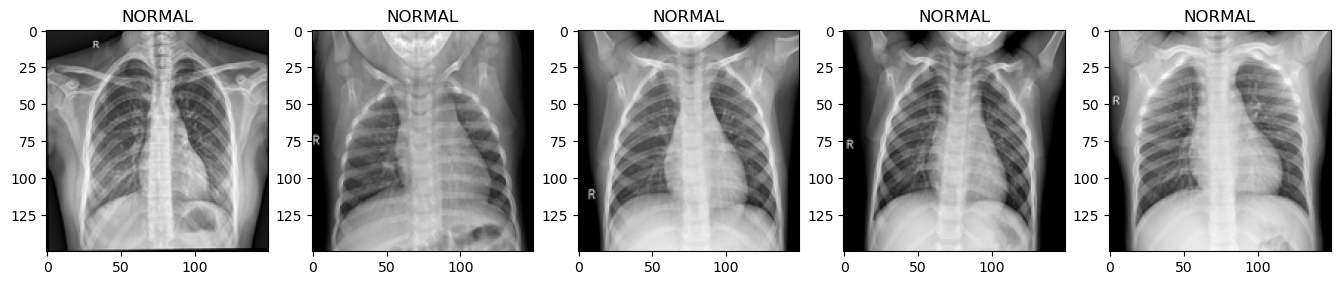

In [6]:
plt.figure(figsize = (20,20))

for i , (img,label) in enumerate(zip(X_train[:5], y_train[:5])):
    plt.subplot(5,6,i+1)
    plt.imshow(img, cmap='gray')
    if label == 0:
        title ="NORMAL"
    elif label == 1:
        title ="PNEUMONIA"
    plt.title(title)

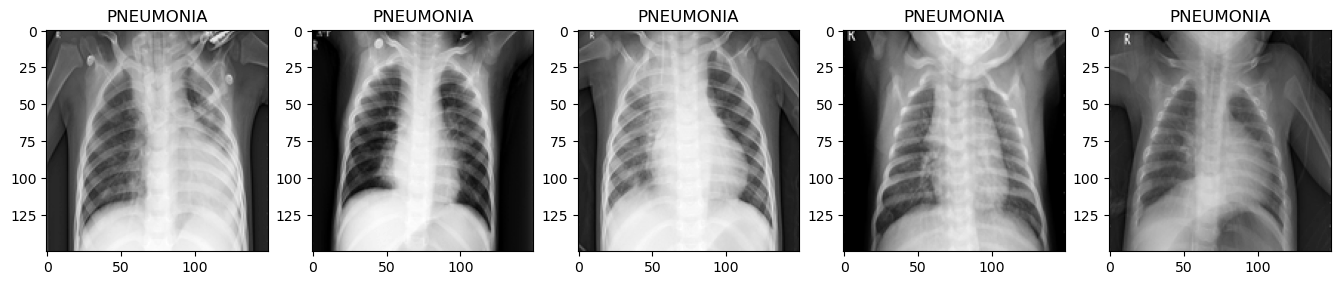

In [7]:
plt.figure(figsize = (20,20))
for i , (img,label) in enumerate(zip(X_train[-6:-1], y_train[-6:-1])):
    plt.subplot(5,6,i+1)
    plt.imshow(img, cmap='gray')
    if label == 0:
        title ="NORMAL"
    elif label == 1:
        title ="PNEUMONIA"
    plt.title(title)

# 1. Baseline Model Construction

## Conversion to tensor object

In [8]:
X_train_tensor = torch.tensor(X_train).unsqueeze(1)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val).unsqueeze(1)
y_val_tensor = torch.tensor(y_val)

(# images, 1 for bw 3 for rgb, image size, image size)
* e.g., (356, 1, 150, 150)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Model Construction

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # padding=1; input image size maintained after conv layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(32 * 37 * 37, 128)  
        self.fc2 = nn.Linear(128, 32)            
        self.fc3 = nn.Linear(32, 1)             

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     
        x = self.pool(F.relu(self.conv2(x))) 
        
        x = torch.flatten(x, 1)                 
        x = F.relu(self.fc1(x))                  
        x = F.relu(self.fc2(x))                   
        # x = torch.sigmoid(self.fc3(x))           
        x = self.fc3(x) # since we are using a BCEWithLogitsLoss applying sigmoid automatically, fc3 does not need activation function
        return x

In [11]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=43808, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

## Training the Model

In [13]:
## parameters
batch_size = 128
num_epochs = 20

In [14]:
train_losses = []

for epoch in range(num_epochs):
    net.train() 
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()  
        outputs = net(images)  
        loss = criterion(outputs, labels.unsqueeze(1).float())  # target: (N, 1)
        loss.backward() 
        optimizer.step()  
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # evaluation
    net.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net(images)
            val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = torch.round(torch.sigmoid(outputs))  # convert to 0 or 1 after sigmoid function is applied
            val_total += labels.size(0)
            val_correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_accuracy = val_correct / val_total
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Loss: 0.2446
Validation Loss: 0.4876, Accuracy: 0.7500
Epoch [2/20], Loss: 0.1004
Validation Loss: 0.4885, Accuracy: 0.7500
Epoch [3/20], Loss: 0.0804
Validation Loss: 0.3372, Accuracy: 0.8750
Epoch [4/20], Loss: 0.0542
Validation Loss: 0.3184, Accuracy: 0.8750
Epoch [5/20], Loss: 0.0569
Validation Loss: 0.7473, Accuracy: 0.6250
Epoch [6/20], Loss: 0.0409
Validation Loss: 0.1408, Accuracy: 0.9375
Epoch [7/20], Loss: 0.0408
Validation Loss: 0.2196, Accuracy: 0.8750
Epoch [8/20], Loss: 0.0223
Validation Loss: 0.4541, Accuracy: 0.8125
Epoch [9/20], Loss: 0.0262
Validation Loss: 0.0877, Accuracy: 1.0000
Epoch [10/20], Loss: 0.0179
Validation Loss: 0.0400, Accuracy: 1.0000
Epoch [11/20], Loss: 0.0130
Validation Loss: 0.2491, Accuracy: 0.8750
Epoch [12/20], Loss: 0.0142
Validation Loss: 0.0051, Accuracy: 1.0000
Epoch [13/20], Loss: 0.0049
Validation Loss: 0.0141, Accuracy: 1.0000
Epoch [14/20], Loss: 0.0028
Validation Loss: 0.0928, Accuracy: 0.9375
Epoch [15/20], Loss: 0.0003
V

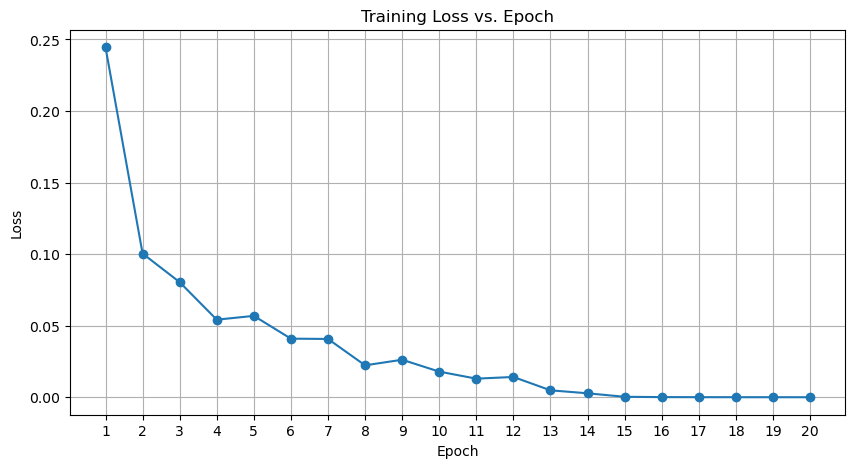

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()

# 2. Baseline Model Evaluation

In [16]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) 
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

왜 train_loader만 셔플?
* 훈련 데이터: shuffle=True로 해두면 모델이 다양한 패턴을 학습할 수 있음
* 검증 및 테스트 데이터: shuffle=False로 설정함으로써 evaluation의 일관성 유지 가능

In [17]:
net.eval()
y_true = []
y_pred = []
y_scores = []

In [18]:
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        scores = torch.sigmoid(outputs)  # probabilistic predictions using sigmoid function
        predictions = torch.round(scores)  # 0 or 1
        
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())
        y_scores.extend(scores.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

## Confusion Matrix & Classification Report

In [19]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 분류 리포트 출력
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[ 79 155]
 [  2 388]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.34      0.50       234
         1.0       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



AUC Score: 0.8477
-------------------------


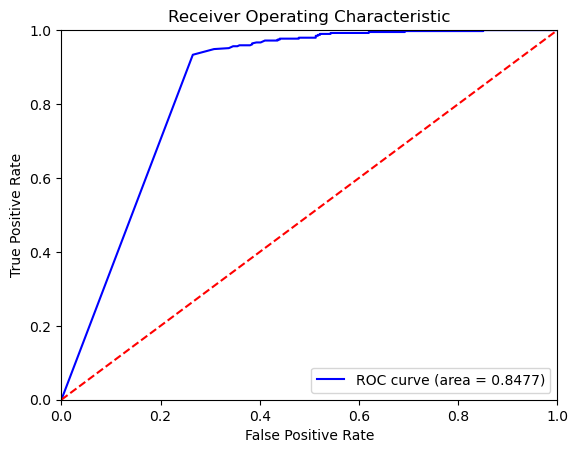

In [20]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")
print("-------------------------")

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 분류기
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Data Augmentation

In [21]:
from torchvision.transforms import v2

In [22]:
img = X_train[0]
img_tensor = v2.ToTensor()(img)

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(contrast=(0.7, 1.3)),
    v2.RandomRotation(degrees=30),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    v2.ToTensor()
])

/Users/mina/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


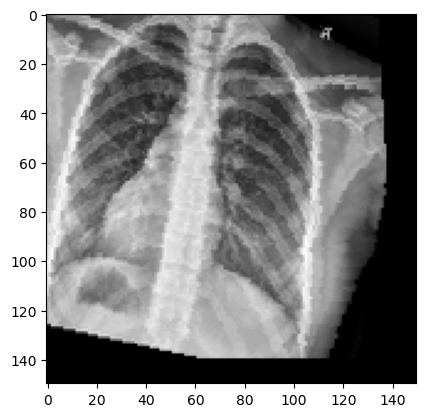

In [23]:
img_trans = transforms(img_tensor)
plt.imshow(np.moveaxis(img_trans.numpy(), 0, -1), cmap = 'gray')
plt.show()

## Defining Augmented Dataset

In [24]:
X_train_aug = []
for img in X_train:
    img = Image.fromarray((img * 255).astype(np.uint8))  # Convert back to PIL Image
    img_transformed = transforms(img)  # Apply transformations
    X_train_aug.append(img_transformed)

In [25]:
X_train_aug = torch.stack(X_train_aug)  # Convert list to tensor
aug_train_loader = DataLoader(TensorDataset(X_train_aug, y_train_tensor), batch_size=32, shuffle=True)

Epoch [1/20], Loss: 0.4643
Validation Loss: 0.7305, Accuracy: 0.6250
Epoch [2/20], Loss: 0.3488
Validation Loss: 0.6998, Accuracy: 0.6875
Epoch [3/20], Loss: 0.2957
Validation Loss: 0.7789, Accuracy: 0.5625
Epoch [4/20], Loss: 0.2430
Validation Loss: 0.7598, Accuracy: 0.6250
Epoch [5/20], Loss: 0.2035
Validation Loss: 1.0064, Accuracy: 0.5625
Epoch [6/20], Loss: 0.1579
Validation Loss: 0.9333, Accuracy: 0.5625
Epoch [7/20], Loss: 0.1423
Validation Loss: 0.4696, Accuracy: 0.7500
Epoch [8/20], Loss: 0.1188
Validation Loss: 0.7516, Accuracy: 0.6875
Epoch [9/20], Loss: 0.0772
Validation Loss: 0.8479, Accuracy: 0.6250
Epoch [10/20], Loss: 0.0579
Validation Loss: 1.7392, Accuracy: 0.6250
Epoch [11/20], Loss: 0.0427
Validation Loss: 0.7371, Accuracy: 0.6250
Epoch [12/20], Loss: 0.0450
Validation Loss: 1.3966, Accuracy: 0.6250
Epoch [13/20], Loss: 0.0277
Validation Loss: 1.2422, Accuracy: 0.6250
Epoch [14/20], Loss: 0.0106
Validation Loss: 1.1691, Accuracy: 0.6250
Epoch [15/20], Loss: 0.0085
V

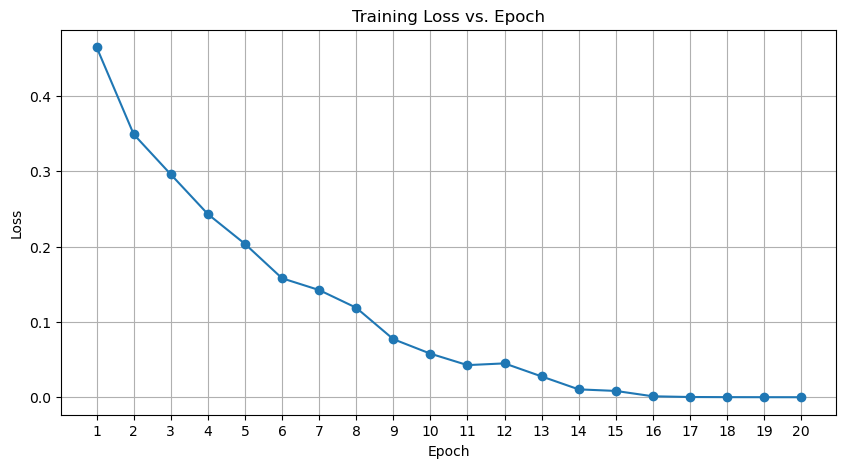

In [26]:
net_aug = Net()  # 데이터 증강을 위한 모델 인스턴스 생성
criterion = nn.BCEWithLogitsLoss()  # 손실 함수
optimizer = optim.Adam(net_aug.parameters())  # 옵티마이저

# 모델 훈련
num_epochs = 20
train_losses_aug = []  # 손실 값을 저장할 리스트

for epoch in range(num_epochs):
    net_aug.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    
    for images, labels in aug_train_loader:  # aug_train_loader 사용
        optimizer.zero_grad()  # 기울기 초기화
        outputs = net_aug(images)  # 모델의 예측
        loss = criterion(outputs, labels.unsqueeze(1))  # 손실 계산
        loss.backward()  # 기울기 계산
        optimizer.step()  # 가중치 업데이트
        running_loss += loss.item()  # 손실 누적

    avg_loss = running_loss / len(aug_train_loader)  # 평균 손실 계산
    train_losses_aug.append(avg_loss)  # 손실 값을 리스트에 저장
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # 검증 단계
    net_aug.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net_aug(images)  # net_aug 사용
            val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = torch.round(torch.sigmoid(outputs))  # 예측을 0 또는 1로 변환
            val_total += labels.size(0)
            val_correct += (predicted == labels.unsqueeze(1)).sum().item()

    val_accuracy = val_correct / val_total
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}')

# 훈련 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_aug, marker='o')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()

In [27]:
net_aug.eval()  

y_true_aug = []
y_pred_aug = []
y_scores_aug = []

In [28]:
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net_aug(images) 
        scores = torch.sigmoid(outputs)  
        predictions = torch.round(scores) 
        
        y_true_aug.extend(labels.numpy()) 
        y_pred_aug.extend(predictions.numpy())  
        y_scores_aug.extend(scores.numpy())  

y_true_aug = np.array(y_true_aug)
y_pred_aug = np.array(y_pred_aug)
y_scores_aug = np.array(y_scores_aug)

In [29]:
cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
print("Confusion Matrix:")
print(cm_aug)

# Classification Report
report_aug = classification_report(y_true_aug, y_pred_aug)
print("Classification Report:")
print(report_aug)

Confusion Matrix:
[[142  92]
 [ 20 370]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72       234
         1.0       0.80      0.95      0.87       390

    accuracy                           0.82       624
   macro avg       0.84      0.78      0.79       624
weighted avg       0.83      0.82      0.81       624



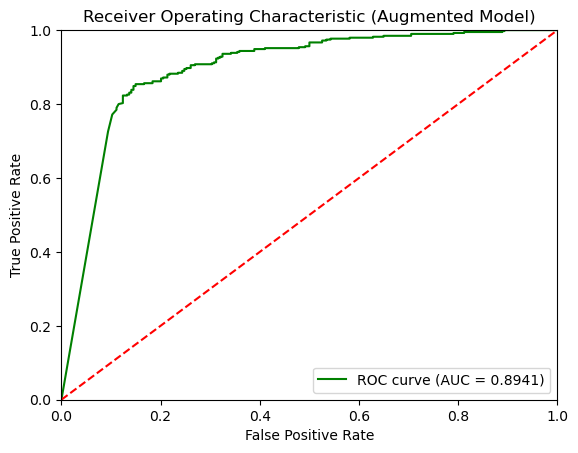

In [32]:
fpr_aug, tpr_aug, thresholds_aug = roc_curve(y_true_aug, y_scores_aug)
roc_auc_aug = auc(fpr_aug, tpr_aug)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_aug, tpr_aug, color='green', label=f'ROC curve (AUC = {roc_auc_aug:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 클래스
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Augmented Model)')
plt.legend(loc="lower right")
plt.show()